# Variational Autoencoder(VAE) with the MINST Dataset with PyTorch #

In [23]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as functional
from torch.autograd import Variable

import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

###           1. CREATE VAE     


In [24]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # потому что 2-мерный - image is flat
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, 7), 
            nn.ReLU(),
            Compress())
        
        
        self.fc_mu = nn.Linear(64, 64)     # мат_ожидание
        self.fc_logvar = nn.Linear(64, 64) # дисперсия
        
        # Decoder:
        self.decoder = nn.Sequential(
            Decompress(),
            nn.ConvTranspose2d(64, 32, 7), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()) # get probability
        
        # reparametrization trick:
    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        e = torch.randn_like(std)
        z = mu + (std * e)
        return z
    
    def generateExample(self, num_examples):
        # x must be 64, 1, 1 tensor
        mu = torch.zeros(num_examples, 64)
        logvar = torch.ones(num_examples, 64)
        z = self.sample(mu, logvar)
        return self.decoder(z)
    
    
    def forward(self, x): # x - batch of images
        print(f"Before encoding: {x.shape}")
        x = self.encoder(x)
        print(f"After encoding: {x.shape}")
        
        mu = self.fc_mu(x)
        mu = torch.zeros(10, 64)
        print(f"Mean (mu) Shape: {mu.shape}")
        logvar = self.fc_logvar(x)
        logvar = torch.ones(10, 64)
        print(f"Log Variance Shape: {logvar.shape}")
        
        z = self.sample(mu, logvar)
        print(f"Z Shape: {z.shape}")
        
        recon_x = self.decoder(z)
        #mu 0 logvar 1 for reconstrion
        print(f"Reconstructed x After Decoding: {recon_x.shape}")
        return recon_x, mu, logvar

    
class Compress(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1) #растянем тензор
    
    
class Decompress(nn.Module):
    def forward(self, input, size=28*28):
        print(input.view(input.size(0), input.size(1), 1, 1).shape)
        return input.view(input.size(0), input.size(1), 1, 1)

def loss_fn(recon_x, x, mu, logvar):
    
    # squared error MSELoss
    loss = functional.mse_loss(recon_x, x, reduction="sum")
    KL_Div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return loss + KL_Div
    #return mse_loss + KL_Div

## GET THE DATASET  

In [25]:
#transform to tensors from [0, 1] to normalized range of [-1, 1]
transform = transforms.ToTensor()

#Download  dataset 
dataset = datasets.MNIST(
    root = "data",
    download = True,
    transform = transform
    )

batch_size = 10

#Create data loaders
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

## Show images

In [26]:
def showImage(img, img_recon, epoch):
    
    #unnormalize
    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    
    #img = img/2 + 0.5
    img = img.numpy()
    plt.title(label="Original Epoch: #"+str(epoch))
    plt.imshow(np.transpose(img, (1, 2, 0)))
    fig.add_subplot(1, 2, 2)
    
    #img_recon = img_recon/2 + 0.5
    img_recon = img_recon.numpy()
    plt.title(label="Reconstruction Epoch: #"+str(epoch))
    plt.imshow(np.transpose(img_recon, (1, 2, 0)))
    plt.show(block=True)
    
def showExample(img):
    
    #unnormalize
    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    #img = img/2 + 0.5
    img = img.numpy()
    plt.title(label="Generated Example")
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show(block=True)

Epoch 1
-----------------------------------


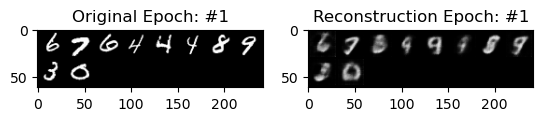

loss: 542.590


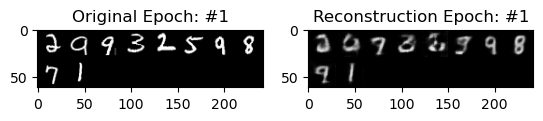

loss: 419.613


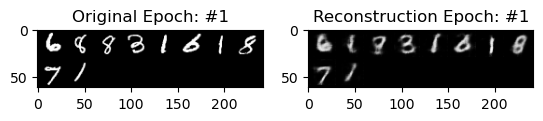

loss: 376.965
Epoch 2
-----------------------------------


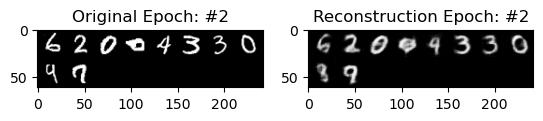

loss: 356.709


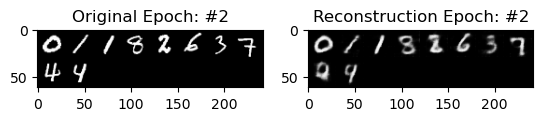

loss: 346.108


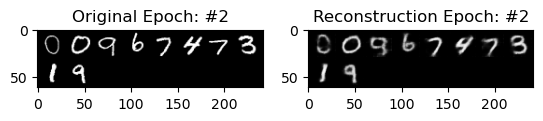

loss: 337.575
Epoch 3
-----------------------------------


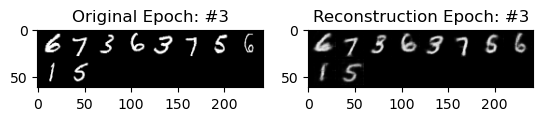

loss: 332.949


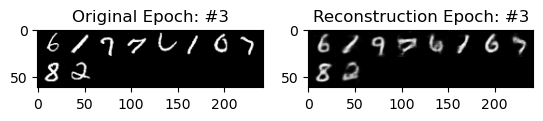

loss: 327.853


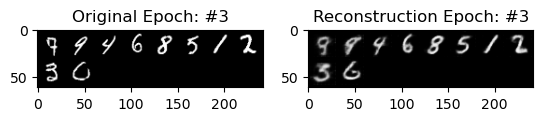

loss: 325.186
Epoch 4
-----------------------------------


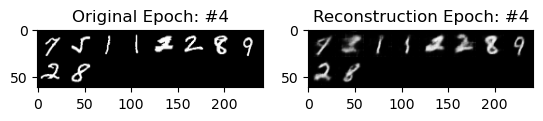

loss: 323.814


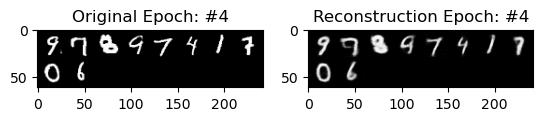

loss: 321.048


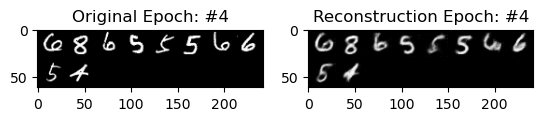

loss: 319.242
Epoch 5
-----------------------------------


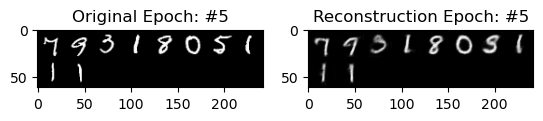

loss: 318.061


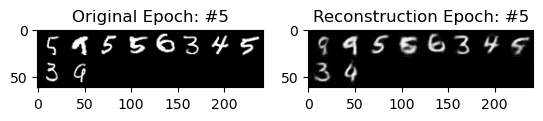

loss: 315.685


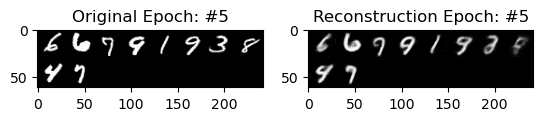

loss: 317.203
Epoch 6
-----------------------------------


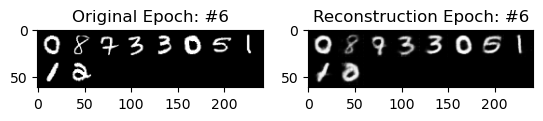

loss: 315.321


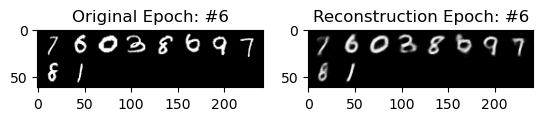

loss: 314.860


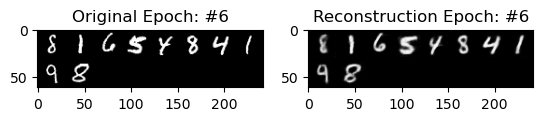

loss: 312.644
Epoch 7
-----------------------------------


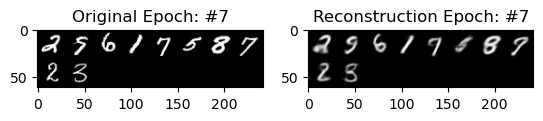

loss: 313.155


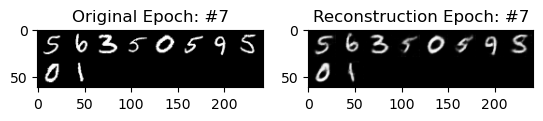

loss: 311.820


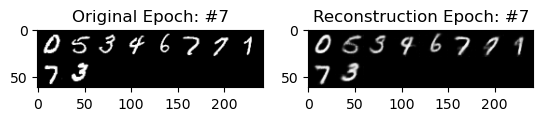

loss: 311.665
Epoch 8
-----------------------------------


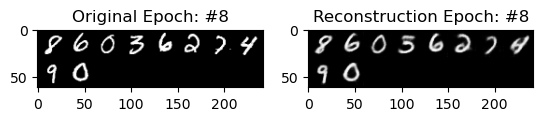

loss: 311.037


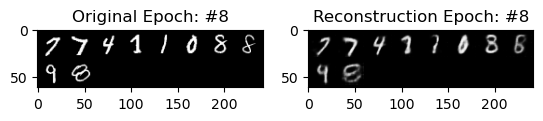

loss: 308.888


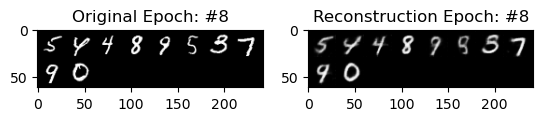

loss: 310.978
Epoch 9
-----------------------------------


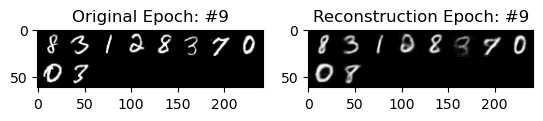

loss: 309.245


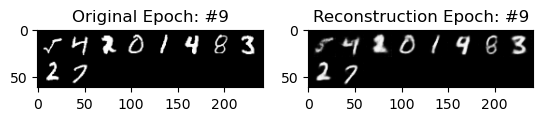

loss: 308.533


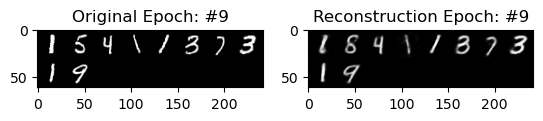

loss: 308.253
Epoch 10
-----------------------------------


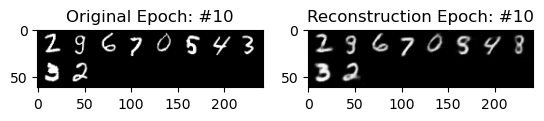

loss: 307.080


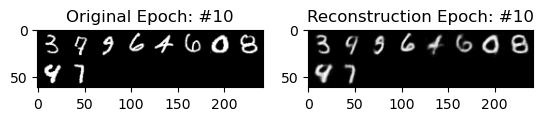

loss: 308.645


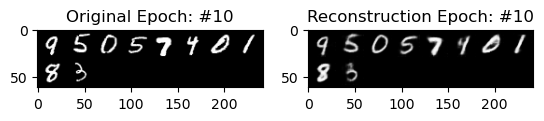

loss: 306.724
Generating a random example...


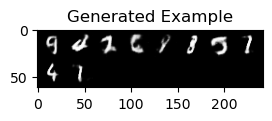

In [27]:
model = VAE()

learning_rate = .001  # шаг спуска - 0.001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
epochs = 10
running_loss = 0.0


for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------------------")
    for idx, (images, _) in enumerate(train_dataloader):
        
        images = images
        recon_x, mu, logvar = model(images)
        loss = loss_fn(recon_x, images, mu, logvar)
        
        optimizer.zero_grad() #обнулим градиенты
        loss.backward()  # calc gradients
        optimizer.step() # do step of grads
        
        # print statistics
        # because loss хранит whole graph of gradients - but we need figures 
        running_loss += loss.item()
        if idx % 2000 == 1999:    # print every 2000 mini-batches
            
            #output the original image and the reconstructed image
            showImage(torchvision.utils.make_grid(images, torchvision.utils.make_grid(recon_x.to("cpu")), t+1)
                      
            #showImage(torchvision.utils.make_grid(recon_x)
            print('loss: %.3f' %(running_loss / 2000))
            running_loss = 0.0
    
print("Generating a random example...")
num_examples = 10
                      
#run the example through the decoder
example = model.generateExample(num_examples)
showExample(torchvision.utils.make_grid(example))

In [29]:
pwd

'/home/iuliiasolomennikova/Desktop/ITMO_ML/MNIST-VAE'